In [2]:
import pandas as pd
import os
import csv
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.dates import DateFormatter

import sklearn.impute
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from missforest import MissForest


# Imputation

Next steps include implementing goodness-of-fit (GoF) indicators ( coefficient of determination, percent bias, Kling-Gupta efficiency, MAE, RMSE, ) to evaluate the performance of the imputation algorithm. An experiment should be replicated many times to present the GoF as a distribution. Then explore how that GoF changes with the amount of missing data (gap sizes) and tuning of hyperparameters.  These GoF indicators can then also be compared to other imputation algorithms to determine if MissForest (or any other more computational involved algorithm) is actually “better” than simple univariate methods.

The goal for the next two weeks is to set up the framework and run the experiments:
- Measurement of GoF indicators
- Multiple replicates of each experiment
- As a function of continuous gap size
- As a function of number of randomly removed samples
- Compare to ‘simple’ methods such as replace with mean or median or linear interpolation


## Goodness-of-fit indicators

### Coefficient of determination ($R^2$)

$$ R^2 = \left [ \frac{\sum_{i=1}^{n}(O_i - \mu_0)(S_i - \mu_s)}{\sqrt{\sum_{i=1}^{n}(O_i - \mu_0)^2}\sqrt{\sum_{i=1}^{n}(O_s - \mu_s)^2}} \right ]$$

### Percent bias (PBIAS)

$$ PBIAS = \left [ \frac{\sum_{i=1}^{n} S_i - O_o}{\sum_{i=1}^{n}O_i} \right ] \times 100$$

### Kling-Gupta efficiency (KGE)

$$ KGE = 1 - \sqrt{(r-1)^2 + (\beta -1)^2 + (\gamma -1)^2} $$

$$\beta = \frac{\mu_s}{\mu_o} $$

$$\gamma = \frac{\sigma_s/\mu_s}{\sigma_o/\mu_o} $$

In [77]:
variable = 'temperature_degrees'
df = pd.read_csv('data.csv', parse_dates=True, index_col=0)

# Define the cutoff date
cutoff_date = "2020-09-01"

# Select rows past the cutoff date
df = df[df.index >=  pd.Timestamp(cutoff_date)]

# Define the cutoff date
cutoff_date = "2024-08-31"

# Select rows past the cutoff date
df = df[df.index <=  pd.Timestamp(cutoff_date)]

# Calculate the percentage of non-missing data for each study site
non_missing_percentage = df.notna().mean() * 100

# Filter study sites with at least 50% non-missing data
selected_sites = non_missing_percentage[non_missing_percentage >=99].index
df_selected = df[selected_sites]

In [78]:
def plot_data_available(df):
    # Creating a boolean DataFrame where True indicates non-missing data
    non_missing_data = ~df.isna()
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)
    
    plt.xlabel('Time')
    plt.ylabel('Study Site ID')


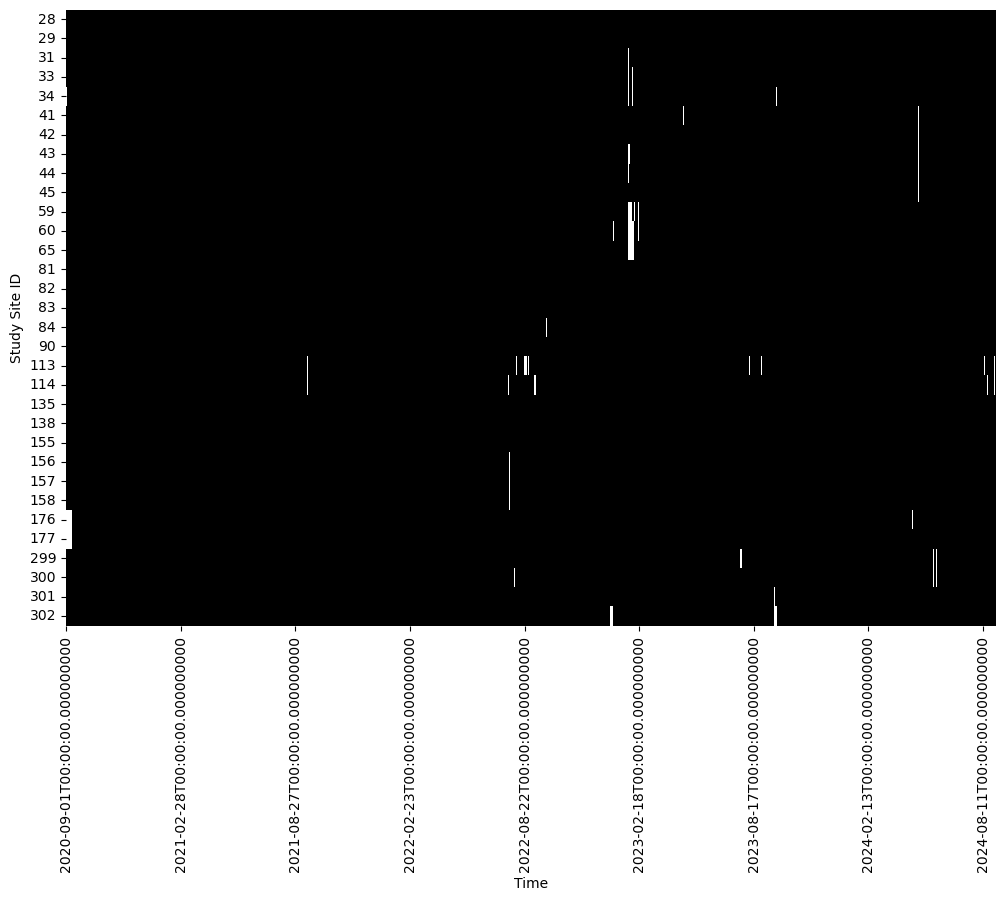

In [79]:
plot_data_available(df_selected)

Dataset consists of 31 "stations" with 1461 observations each.

## Remove contiguous segments

At each station remove contiguous segments (having lengths 7, 14, 21, 30 days)

In [242]:
df = df_selected.copy()

# Function to randomly set a n-day contiguous segment as missing for each column
n = 180
for col in df.columns:
    # Randomly select the start of the n-day segment
    start_idx = np.random.randint(0, len(df) - n)
    end_idx = start_idx + n

    # Set the values in this range to NaN
    df.iloc[start_idx:end_idx, df.columns.get_loc(col)] = np.nan

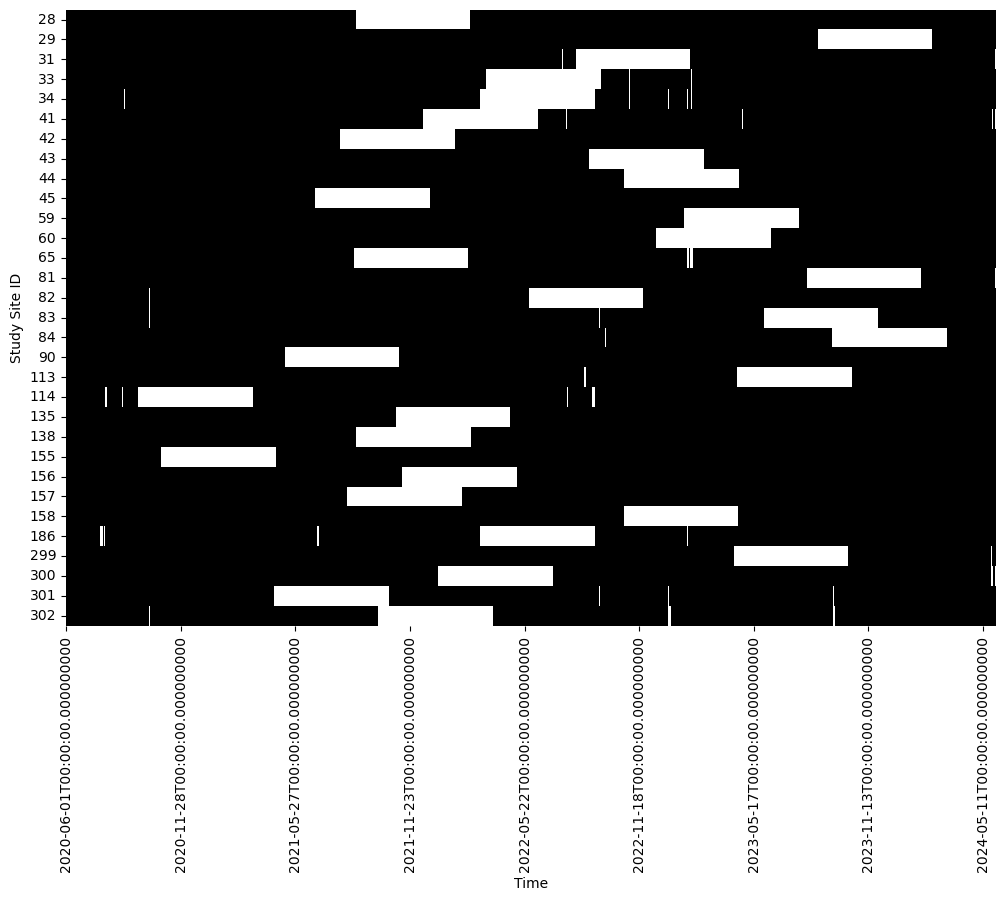

In [243]:
plot_data_available(df)

In [257]:
def run_experiment(method = 'MF', gap_type = 'continuous', n = 1):
    
    variable = 'temperature_degrees'
    df = pd.read_csv('data.csv', parse_dates=True, index_col=0)
    
    # Define the cutoff date
    cutoff_date = "2020-06-01"
    
    # Select rows past the cutoff date
    df = df[df.index >=  pd.Timestamp(cutoff_date)]
    
    # Define the cutoff date
    cutoff_date = "2024-06-01"
    
    df = df[df.index <  pd.Timestamp(cutoff_date)]
    
    # Calculate the percentage of non-missing data for each study site
    non_missing_percentage = df.notna().mean() * 100
    
    # Filter study sites with at least 50% non-missing data
    selected_sites = non_missing_percentage[non_missing_percentage >= 99].index
    df_selected = df[selected_sites]

    # artifical gaps 
    df = df_selected.copy()


    if gap_type == 'continuous':
        # randomly set a n-day contiguous segment as missing for each column
        for col in df.columns:
            # Randomly select the start of the n-day segment
            start_idx = np.random.randint(0, len(df) - n)
            end_idx = start_idx + n
        
            # Set the values in this range to NaN
            df.iloc[start_idx:end_idx, df.columns.get_loc(col)] = np.nan
    elif gap_type == 'random':

        # remove randomly selected n days as missing for each column
        for col in df.columns:
            # Randomly sample unique dates
            random_dates = np.random.choice(df.index, size=n, replace=False)
            
            # Set the values to NaN for those dates
            df.loc[random_dates, col] = np.nan
    else:
        raise Exception(f'Unknown gap_type {gap_type}')

    if method == 'MF':
        # Imputer
        clf = RandomForestClassifier(n_jobs=-1)
        rgr = RandomForestRegressor(n_jobs=-1, n_estimators=5)
    
        imputer = MissForest(clf, rgr, verbose=1,max_iter=5)
        df_sim = imputer.fit_transform(df)
    
    elif method == 'linear':
        df_sim = df.interpolate(method='linear')
    else:
        raise Exception(f'Unknown method {method}')
          
    
    suffix = f'_{gap_type}_{n}_{method}'
    # save output
    df_selected.to_csv(f'obs{suffix}.csv')
    df_imputed.to_csv(f'sim{suffix}.csv')
    

In [258]:
method = 'linear'
gap_type = 'continuous'
for n in [7, 14, 21, 30, 60, 180, 365]:
    run_experiment(gap_type=gap_type, n=n, method=method)

gap_type = 'random'
for n in [30, 60, 90, 120, 180, 365]:
    run_experiment(gap_type=gap_type, n=n, method=method)


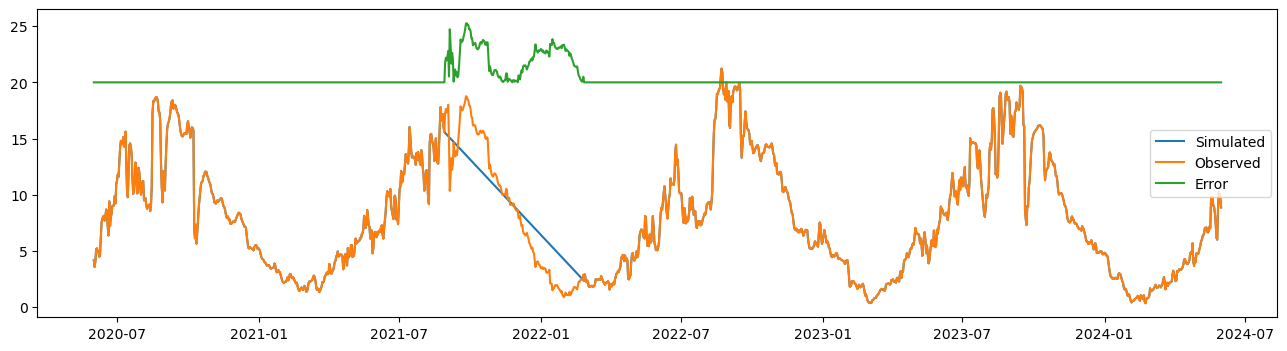

In [255]:
station_id = '28'
plt.figure(figsize=(16,4))
plt.plot(df_imputed[station_id], label='Simulated')
plt.plot(df_selected[station_id], label='Observed')

plt.plot(abs(df_selected[station_id] - df_imputed[station_id])+20, label='Error')

plt.legend()

## Calculate GoFs

In [217]:
S = df_imputed
O = df_selected

μo = O.mean()
σo = O.std()

μs = S.mean()
σs = S.std()

# bias ratio
β = μs / μo

# variability ratio
γ = (σs/μs) / (σo/μo)

## correlation coefficient
r = df_selected.corrwith(df_imputed)

In [218]:
R2 = ((O - μo) * (S - μs)).sum() / (np.sqrt(((O-μo)**2).sum()) * np.sqrt(((S-μs)**2).sum()))

PBIAS = (S - O).sum() / O.sum() * 100

KGE = 1 - np.sqrt((r - 1)**2 + (β - 1)**2 + (γ - 1)**2)


In [195]:
def KGE(S, O):
    μo = O.mean()
    σo = O.std()

    μs = S.mean()
    σs = S.std()

    # bias ratio
    β = μs / μo

    # variability ratio
    γ = (σs/μs) / (σo/μo)

    ## correlation coefficient
    r = O.corrwith(S)

    return  1 - np.sqrt((r - 1)**2 + (β - 1)**2 + (γ - 1)**2)


Text(0.5, 1.0, 'KGE')

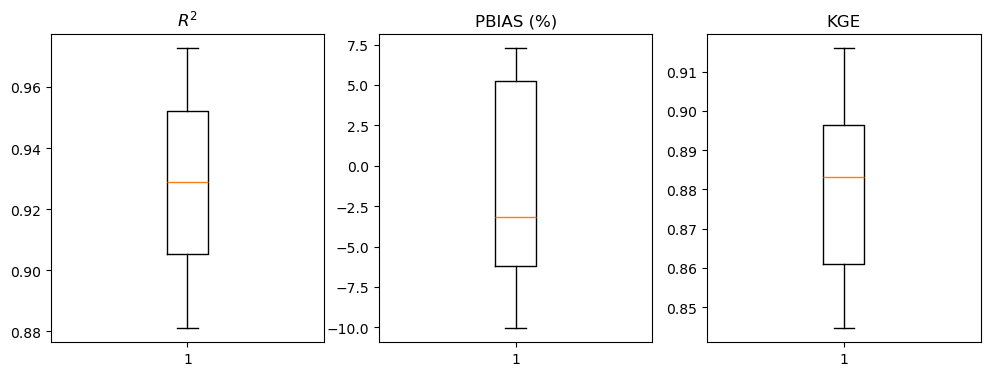

In [219]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].boxplot(R2)
ax[0].set_title('$R^2$')

ax[1].boxplot(PBIAS)
ax[1].set_title('PBIAS (%)')

ax[2].boxplot(KGE)
ax[2].set_title('KGE')


In [262]:
def gof(O, S):
        
    μo = O.mean()
    σo = O.std()
    
    μs = S.mean()
    σs = S.std()
    
    # bias ratio
    β = μs / μo
    
    # variability ratio
    γ = (σs/μs) / (σo/μo)
    
    ## correlation coefficient
    r = O.corrwith(S)
    
    R2 = ((O - μo) * (S - μs)).sum() / (np.sqrt(((O-μo)**2).sum()) * np.sqrt(((S-μs)**2).sum()))
    
    PBIAS = (S - O).sum() / O.sum() * 100
    
    KGE = 1 - np.sqrt((r - 1)**2 + (β - 1)**2 + (γ - 1)**2)

    return pd.DataFrame({'R2': R2, 'PBIAS': PBIAS, 'KGE': KGE})

In [307]:
performance = {}

gap_type = 'continuous'
performance[gap_type] = { 'R2': {}, 'PBIAS': {}, 'KGE': {} }
for n in [7, 14, 21, 30, 60, 180, 365]:
    for method in ['', '_linear']:
        suffix = f'_{gap_type}_{n}{method}'
    
        S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
        O = pd.read_csv(f'obs{suffix}.csv', index_col=0)

        results = gof(S, O)

        if method == '':
            method = 'MF'
        elif method == '_linear':
            method = 'LR'
            
        position = f'{n} {method}'
        performance[gap_type]['R2'][position] = results['R2']
        performance[gap_type]['PBIAS'][position] = results['PBIAS']
        performance[gap_type]['KGE'][position] = results['KGE']

        
gap_type = 'random'
performance[gap_type] = { 'R2': {}, 'PBIAS': {}, 'KGE': {} }
for n in [30, 60, 90, 120, 180, 365]:
    for method in ['', '_linear']:
        suffix = f'_{gap_type}_{n}{method}'
    
        S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
        O = pd.read_csv(f'obs{suffix}.csv', index_col=0)

        results = gof(S, O)

        if method == '':
            method = 'MF'
        elif method == '_linear':
            method = 'LR'
            
        position = f'{n} {method}'

        performance[gap_type]['R2'][position] = results['R2']
        performance[gap_type]['PBIAS'][position] = results['PBIAS']
        performance[gap_type]['KGE'][position] = results['KGE']

for gap_type in ['continuous', 'random']:
    for metric in ['R2', 'PBIAS', 'KGE']:
        performance[gap_type][metric] = pd.DataFrame(performance[gap_type][metric])

In [308]:
performance['continuous']['R2']

,7 MF,7 LR,14 MF,14 LR,21 MF,21 LR,30 MF,30 LR,60 MF,60 LR,180 MF,180 LR,365 MF,365 LR
113,0.995440,0.979628,0.997115,0.979628,0.990369,0.979628,0.992994,0.979628,0.991071,0.979628,0.864070,0.979628,0.836888,0.979628
114,0.993456,0.984908,0.992997,0.984908,0.978766,0.984908,0.983555,0.984908,0.985913,0.984908,0.864311,0.984908,0.913147,0.984908
135,0.999987,0.959753,0.999815,0.959753,0.998465,0.959753,0.992622,0.959753,0.997786,0.959753,0.949275,0.959753,0.855885,0.959753
138,0.999705,0.985827,0.998980,0.985827,0.994683,0.985827,0.999141,0.985827,0.992464,0.985827,0.951549,0.985827,0.831125,0.985827
155,0.998989,0.964891,0.999380,0.964891,0.999688,0.964891,0.990752,0.964891,0.963578,0.964891,0.925256,0.964891,0.852861,0.964891
156,0.999789,0.959794,0.997777,0.959794,0.999113,0.959794,0.994016,0.959794,0.999012,0.959794,0.920867,0.959794,0.854957,0.959794
157,0.999897,0.962414,0.999937,0.962414,0.996748,0.962414,0.984505,0.962414,0.962491,0.962414,0.959125,0.962414,0.859130,0.962414
158,0.999937,0.978837,0.999341,0.978837,0.998029,0.978837,0.999017,0.978837,0.979831,0.978837,0.971354,0.978837,0.884295,0.978837
186,0.998991,0.956241,0.997814,0.956241,0.999109,0.956241,0.998087,0.956241,0.952393,0.956241,0.928259,0.956241,0.898130,0.956241
28,0.999830,0.985605,0.999800,0.985605,0.999550,0.985605,0.995345,0.985605,0.989108,0.985605,0.948970,0.985605,0.862951,0.985605


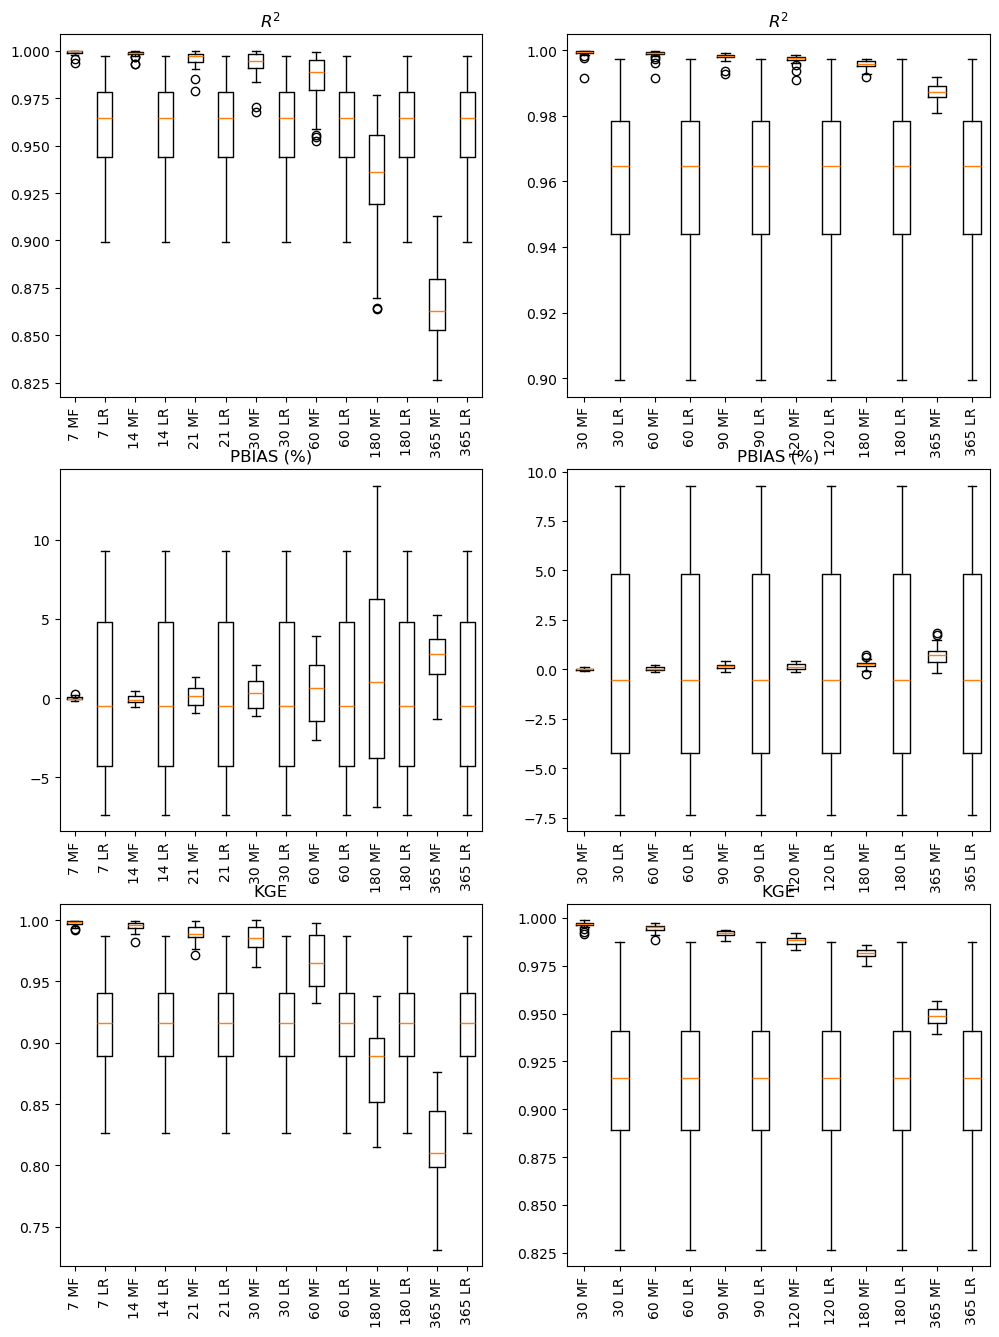

In [332]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

for i, gap_type in enumerate(['continuous', 'random']):
    labels = list(performance[gap_type]['R2'].columns)
    
    ax[0,i].boxplot(performance[gap_type]['R2'])
    ax[0,i].set_xticklabels(labels, rotation=90)
    ax[0,i].set_title('$R^2$')

    ax[1,i].boxplot(performance[gap_type]['PBIAS'])
    ax[1,i].set_xticklabels(labels, rotation=90)
    ax[1,i].set_title('PBIAS (%)')

    ax[2,i].boxplot(performance[gap_type]['KGE'])
    ax[2,i].set_xticklabels(labels, rotation=90)
    ax[2,i].set_title('KGE')
    
plt.show()

In [273]:
results = gof(S, O)

<Axes: >

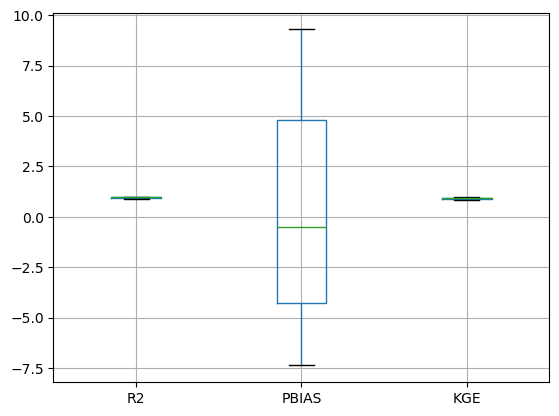

In [274]:
results.boxplot()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1ddbe73fe0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1ddbe30530>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1ddbe73d40>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1ddbe30980>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1ddbe30c80>,
 'means': []}

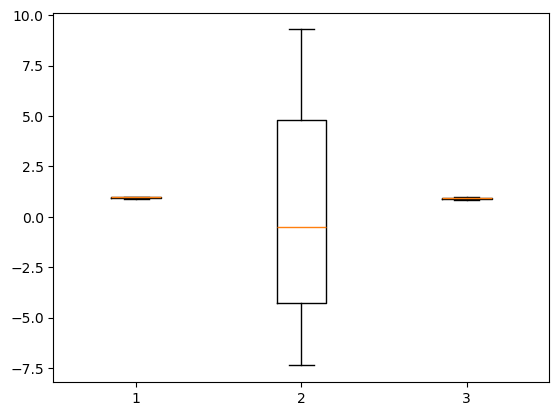

In [272]:

plt.boxplot(gof(S,O), positions)

AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

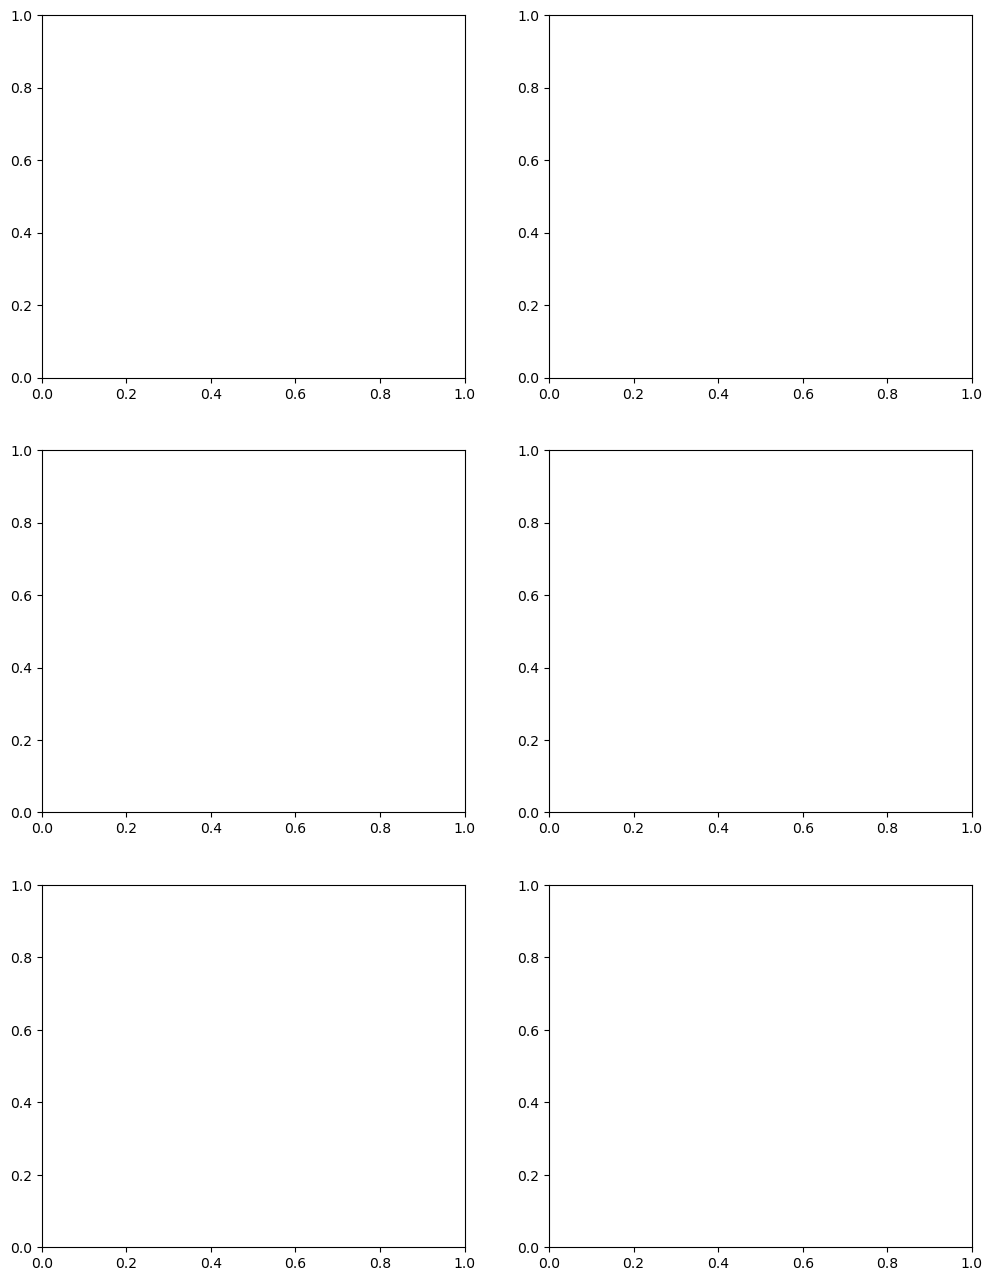

In [270]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

ax[0].boxplot(R2)
ax[0].set_title('$R^2$')

ax[1].boxplot(PBIAS)
ax[1].set_title('PBIAS (%)')

ax[2].boxplot(KGE)
ax[2].set_title('KGE')